Michael Lepore
CS548 - HW4 - MSINT Classifier

## Model 1

I've used LR (among other things) in the past with MSINT and it had shown pretty good test/train accuracy,
so lets start with that - so we can setup the code and have a first model accuracy - that will give us things to compare to - before we move onto other things


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

train_data = pd.read_csv("train.csv")

# lets first bring out data along
y = train_data['label']
X = train_data.drop('label', axis=1)

# now lets split to test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lets setup the code framework for a base model and go from there.
def run_model(model, data):
    data_processed = preprocess_X(data)
    results = model.predict(data_processed)
    return postprocess_predictions(results)

def preprocess_X(data):
    # I've had luck normalizing the pixel values to 0-1 in the past
    return data.astype('float64') / 255.0

def postprocess_predictions(predictions):
    return predictions

def preprocess_y(y_train):
    return y_train

def train_model(X_train, y_train):
    X_train_preprocess = preprocess_X(X_train)
    y_train_preprocess = preprocess_y(y_train)

    # Initialize and train the Logistic Regression model
    lr_model = LogisticRegression(max_iter=1000) # Increased max_iter
    lr_model.fit(X_train_preprocess, y_train_preprocess)

    train_predictions = lr_model.predict(X_train_preprocess)
    train_accuracy = accuracy_score(y_train_preprocess, train_predictions)

    print("Training accuracy: ", train_accuracy)

    return lr_model

lr_model = train_model(X_train, y_train)
lr_predictions = run_model(lr_model, X_test)
y_test_preprocess = preprocess_y(y_test)
lr_test_accuracy = accuracy_score(y_test_preprocess, lr_predictions)

print("Test accuracy: ", lr_test_accuracy)


/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: divide by zero encountered in matmul
  grad[:, :n_features] = grad_pointwise.T @ X + l2_reg_strength * weights
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:336: RuntimeWarning: over

Training accuracy:  0.945625
Test accuracy:  0.919404761904762


/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [2]:
# Ok - we have a very basic model - seems to do well on our test data, so now lets run the
# model against our test data and submit it and see how we do

test_data = pd.read_csv("test.csv")

def create_submission_file(model, filename):
    labels = run_model(model, test_data)
    df = pd.DataFrame( {
        'ImageId' : range(1, len(labels) + 1),
        'Label' : labels
        })
    df.to_csv(filename, index=False)

create_submission_file(lr_model, 'lr_submission_file.csv')



/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Ok, we have our first submission.  91.775%.  Not terrible, but not really good either (#1146 on the leaderboard).


Now that we have a basic code framework that does:

1 - Preprocessing (though very basic - just converting the pixel value to from 0-255 to a 0-1 scale)
2 - Training and accuracy comparison - both on the training set and our test set

We can start to progress and see what else we can do.  This time, lets start building a CNN instead.

## Model 2 CNN

Lets start with a basic CNN - we'll use a 3x3 filter

In [3]:
import keras
from keras import *
from keras.layers import *

# We will go from a pandas dataframe to a 28x28x1 matrix
def preprocess_X(X):
    X_preprocess = X / 255
    X_preprocess = X_preprocess.values.reshape(-1,28,28,1)
    return X_preprocess

def preprocess_y(y_train):
    return keras.utils.to_categorical(y_train, 10)

def postprocess_predictions(predictions):
    return np.argmax(predictions, axis=1).tolist()

def train_cnn_model(X_train, y_train):
    X_train_preprocess = preprocess_X(X_train)
    y_train_preprocess = preprocess_y(y_train)

    # Create a sequential classifier
    classifier = Sequential()

    # Add our CNN Layers - 3x3 filter
    classifier.add(Conv2D(32, (3,3), input_shape=(28,28,1), activation='relu'))
    # Now pool features in a 2x2 Pool
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Add a second CNN layer
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten before moving over to other layers
    classifier.add(Flatten())
    
    # Now we'll add 2 layers 128/256 nodes
    classifier.add(Dense(units=128, activation='relu'))
    classifier.add(Dense(units=256, activation='relu'))

    # Finally a softmax layer with 10 units (one for each digit)
    classifier.add(Dense(units=10, activation='softmax'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Need to convert our y_train to categorical for this to work

    classifier.fit(X_train_preprocess, y_train_preprocess, batch_size = 128, epochs=15, validation_split=0.1)
    
    train_predictions = classifier.predict(X_train_preprocess)
    train_classes =  postprocess_predictions(train_predictions)
    train_accuracy = accuracy_score(y_train, train_classes)

    print("Training accuracy: ", train_accuracy)

    return classifier

cnn_model = train_cnn_model(X_train, y_train)


Epoch 1/15


/opt/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5573 - loss: 0.2393 - val_accuracy: 0.9658 - val_loss: 0.0253
Epoch 2/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9658 - loss: 0.0223 - val_accuracy: 0.9783 - val_loss: 0.0152
Epoch 3/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9781 - loss: 0.0134 - val_accuracy: 0.9833 - val_loss: 0.0121
Epoch 4/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9851 - loss: 0.0102 - val_accuracy: 0.9818 - val_loss: 0.0118
Epoch 5/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9875 - loss: 0.0089 - val_accuracy: 0.9842 - val_loss: 0.0098
Epoch 6/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9907 - loss: 0.0062 - val_accuracy: 0.9872 - val_loss: 0.0091
Epoch 7/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9917 - loss: 0.0054 - val_accuracy: 0.9869 - val_loss: 0.0086
Epoch 8/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9941 - loss: 0.0043 - val_accuracy: 0.9833 - val

In [4]:
cnn_predictions = run_model(cnn_model, X_test)
cnn_test_accuracy = accuracy_score(y_test, cnn_predictions)

print("Test accuracy: ", cnn_test_accuracy)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test accuracy:  0.9891666666666666


In [5]:
create_submission_file(cnn_model, 'cnn1_submission_file.csv')


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Awesome - we now have a 98.717% accuracy rate.  That is better.  We've moved 1/2 way up - #624 on the leaderboard.

A quick recap on what we've done:

* We have a first convolutional layers with a 3x3 matrix with 32 features - which we then downsampole using a 2x2 max pooling layer.
* After some experimentation - I added a second convolutional layer - also 32 features in a 3x3 matrix, again with a 2x2 max pooling layer - to help improve accuracy (it helped a bit - we went from 98.4 to 98.7% accuracy in our submission)
* We need to then flatten the CNN output (since its in a 2 dimensional matrix, and a normal neural net needs a single dimension)
* We take the flattened output of the CNN and then feed that into 2 more fully connected neural net layers with 128 and 256 nodes respectively.
* We feed the output of the CNN into a layer that uses a 10 node softmax layer to predict the overall probability of the image being one of the classes - and then pick the highest probabiltity in a post-process step.

We can use that to check our accuracy and create our submission file.

Now we are likely a bit over-fit - since our training set validation is coming in at 99.8+% accuracy and our test set is coming in at ~98.5%.

So for our next submission, I'm going to try and create some synthetic data based on the images to try and fix our overfitting.


## Model 3

I'm going to add some steps in the beginning of our train_model function to add some synthetic data.  The nice thing is that Keras provides us with functions to do this pretty easily.

Lets see what happens if we add random rotation, image shifting and zooming to our data.  We could also experiment with recoloring or doing inversion if that makes sense.

We will also increase the number of epochs since we're going to be running data through that has changed - it won't always be the same data.

In [20]:


def train_cnn_model2(X_train, y_train):
    X_train_preprocess = preprocess_X(X_train)
    y_train_preprocess = preprocess_y(y_train)

    # Create a sequential classifier
    classifier = Sequential()

    # So - we tried lots of these agumentation methods, and none of them seemed to help that much.
    # Rotation and zoom of .05 helped a bit, but overall not great performance.
    # When used in combination wtih the dropout - seems like dropout is better to avoid overfitting here
    data_augmentation = Sequential([
        layers.RandomRotation(0.12),
        #layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=0),
        #layers.RandomZoom(0.05),
        #layers.RandomInvert(), 
        #layers.RandomBrightness(0.1), Brightness and contrast seem to hurt our model
        #layers.RandomContrast(0.1)
    ])
    classifier.add(Input(shape=(28,28,1)))
    #classifier.add(data_augmentation)
    
    # Add our CNN Layers - 3x3 filter - input 28,28,1, output 26x26x32
    classifier.add(Conv2D(32, (3,3), activation='relu'))
    # Now pool features in a 2x2 Pool - input 26x26x32, output 13x13x32
    #classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Add a second CNN layer - input 13x13x16, output 11x11x16
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    # input 11x11x32, output 6x6x32
    #classifier.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Add a third CNN layer - input 6x6x16, output 5x5x16 
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    # input 11x11x32, output 3x3x16
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten before moving over to other layers
    classifier.add(Flatten())

    # Lets see if adding dropout will help with overfitting
    classifier.add(Dropout(0.5))
    
    # Now we'll add 2 layers 128/256 nodes
    classifier.add(Dense(units=128, activation='relu'))
    classifier.add(Dense(units=256, activation='relu'))

    # Finally a softmax layer with 10 units (one for each digit)
    classifier.add(Dense(units=10, activation='softmax'))

    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Need to convert our y_train to categorical for this to work

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    classifier.fit(X_train_preprocess, y_train_preprocess, batch_size = 128, epochs=50, validation_split=0.1)
    
    train_predictions = classifier.predict(X_train_preprocess)
    train_classes =  postprocess_predictions(train_predictions)
    train_accuracy = accuracy_score(y_train, train_classes)

    print("Training accuracy: ", train_accuracy)

    return classifier

cnn_model2 = train_cnn_model2(X_train, y_train)

Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6841 - loss: 0.1809 - val_accuracy: 0.9774 - val_loss: 0.0163
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9706 - loss: 0.0186 - val_accuracy: 0.9845 - val_loss: 0.0109
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9800 - loss: 0.0131 - val_accuracy: 0.9884 - val_loss: 0.0083
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9853 - loss: 0.0096 - val_accuracy: 0.9875 - val_loss: 0.0078
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9865 - loss: 0.0083 - val_accuracy: 0.9890 - val_loss: 0.0085
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9907 - loss: 0.0063 - val_accuracy: 0.9890 - val_loss: 0.0081
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9918 - loss: 0.0056 - val_accuracy: 0.9893 - val_loss: 0.0075
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9912 - loss: 0.0057 - val_accu

Did a bunch of experimentation with data augmentation - tried rotation, shifting, zooming, brightness and contrast changes - both with small and larger factors.

Turns out that what I found was:
* Rotation and zoom helped overall accuracy (reduced overfitting) but only by a little bit when the values were low
* Translation, Brightness, Contrast and Inversion didn't help - perhaps because with this dataset the images are already pretty optimized.

So I looked at other ways to make overfitting a bit better - and was able to add a dropout layer - with a .5 probability - and that performed pretty well, increasing our regognition rate on our test set up to the 99% range.

I also tried increasing the number of filters to 64 (from 32) and saw a degration in the overall results, so I kept the filters to 32

The inceased epochs also didn't help - we seemed to flatten out around 15/16 epochs.

I was surprised that adding the dropout layer was the best improvement, but the data holds.

Ended up spending some time away, and reading a few things, and ended up back here trying to figure things out - started to play around with the network architecture.

Also experimented with the number of epochs and the overall architecture of the net.  Followed some "rules of thumb" for building networks.  Things that I tried and how they worked
* Pooling layers after every CNN layer - did not work well
* Different convolutional windows (ended at 5x5 and then 3x3) - ended up just sticking with 3x3 everywhere.
* Figuring out the best combination of # of filters and layers and training time.  Tried:
  * 3 layers - 32, 32, 16
  * 2 layers - 96, 96 - this was SUPER slow
  * 3 layers - 32, 32, 32 - seemed to be the best tradeoff of timing to performance 
* Increasing the number of training epochs - ended up at 50 - but added early stopping if necessary.
  * Interestingly we would early stop with fewer layers with more filters.  But with 3 layers and 32 filters, we didn't early stop.

In [21]:
cnn2_predictions = run_model(cnn_model2, X_test)
cnn2_test_accuracy = accuracy_score(y_test, cnn2_predictions)

print("Test accuracy: ", cnn2_test_accuracy)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test accuracy:  0.991547619047619


In [22]:
create_submission_file(cnn_model2, 'cnn2_submission_file.csv')


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Awesome - we now have a 99.106% accuracy rate after a few rounds of chagnes.  Up to #356 on the leaderboard.


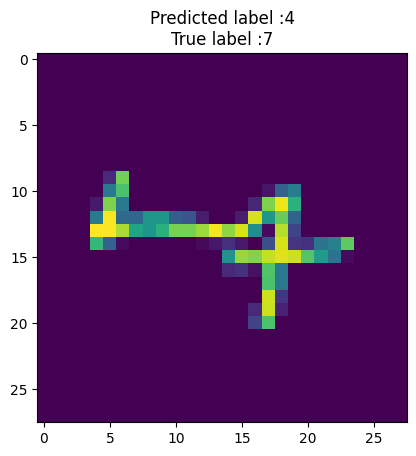

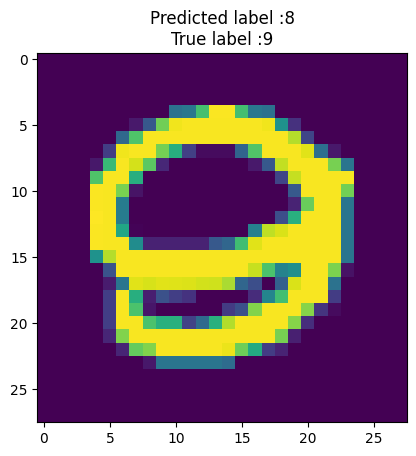

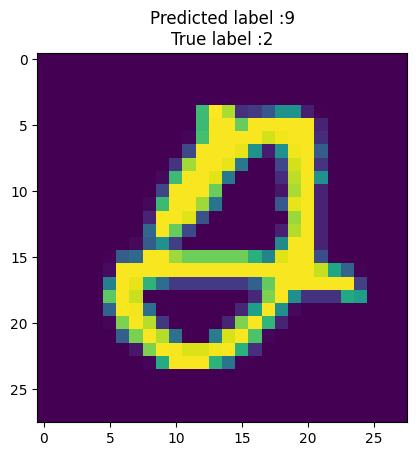

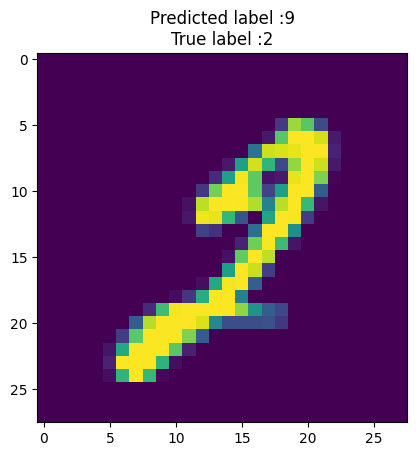

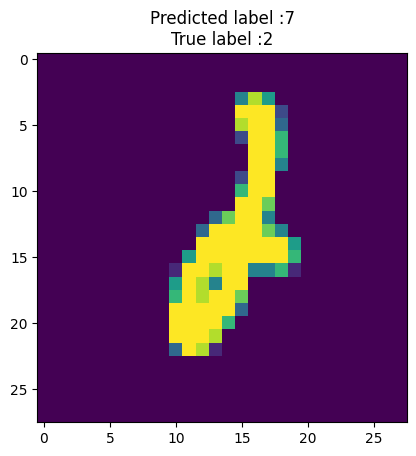

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Out of curiosity, lets see what is different between the two and show the errors
different_indices = np.where(y_test != cnn2_predictions)[0]

df = pd.DataFrame()
df['actual'] = y_test
df['predicted'] = cnn2_predictions

different = df[df['actual']!=df['predicted']]
for index, row in different.head().iterrows():
    plt.title("Predicted label :{}\nTrue label :{}".format(row.predicted, row.actual))
    plt.imshow(X_test.loc[index].values.reshape(28,28,1)) 
    plt.show()
